

<link rel="stylesheet" href="/mediapipe/site.css">

# Hand gesture recognition model customization


## Prerequisites

Install the MediaPipe Model Maker package.

In [ ]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow-metadata to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.4 MB/s eta 0:00:00
  Creat

Import the required libraries.

In [ ]:
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
from tensorboard.backend.event_processing import event_accumulator

In [ ]:
%matplotlib inline

## Simple End-to-End Example

This end-to-end example uses Model Maker to customize a model for on-device gesture recognition.

### Get the dataset

The dataset for gesture recognition in model maker requires the following format: `<dataset_path>/<label_name>/<img_name>.*`. In addition, one of the label names (`label_names`) must be `none`. The `none` label represents any gesture that isn't classified as one of the other gestures.

This example uses a rock paper scissors dataset sample which is downloaded from GCS.

In [ ]:
# !wget https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
# !unzip rps_data_sample.zip
# dataset_path = "rps_data_sample"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/dataset/asl_alphabet_train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/Y/Y190.jpg  
  inflating: asl_alphabet_train/Y/Y1900.jpg  
  inflating: asl_alphabet_train/Y/Y1901.jpg  
  inflating: asl_alphabet_train/Y/Y1902.jpg  
  inflating: asl_alphabet_train/Y/Y1903.jpg  
  inflating: asl_alphabet_train/Y/Y1904.jpg  
  inflating: asl_alphabet_train/Y/Y1905.jpg  
  inflating: asl_alphabet_train/Y/Y1906.jpg  
  inflating: asl_alphabet_train/Y/Y1907.jpg  
  inflating: asl_alphabet_train/Y/Y1908.jpg  
  inflating: asl_alphabet_train/Y/Y1909.jpg  
  inflating: asl_alphabet_train/Y/Y191.jpg  
  inflating: asl_alphabet_train/Y/Y1910.jpg  
  inflating: asl_alphabet_train/Y/Y1911.jpg  
  inflating: asl_alphabet_train/Y/Y1912.jpg  
  inflating: asl_alphabet_train/Y/Y1913.jpg  
  inflating: asl_alphabet_train/Y/Y1914.jpg  
  inflating: asl_alphabet_train/Y/Y1915.jpg  
  inflating: asl_alphabet_train/Y/Y1916.jpg  
  inflating: asl_alphabet_train/Y/Y1917.jpg  
  inflating: asl_alphabet_train

In [ ]:
dataset_path= '/content/asl_alphabet_train'

Verify by printing the labels. There should be one of them being the `none` gesture.

In [ ]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)

/content/asl_alphabet_train
['N', 'E', 'M', 'Q', '5', 'A', '8', 'T', '0', '6', 'I', 'V', 'D', 'W', 'X', 'S', '3', 'K', 'H', 'B', 'Y', 'None', 'L', 'R', 'U', '4', 'F', '2', '7', 'G', 'C', 'J', 'O', '9', 'P', '1', 'space', 'Z', 'del']


To better understand the dataset, plot a couple of example images for each gesture.

<ipython-input-97-63df9954d3e1>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))


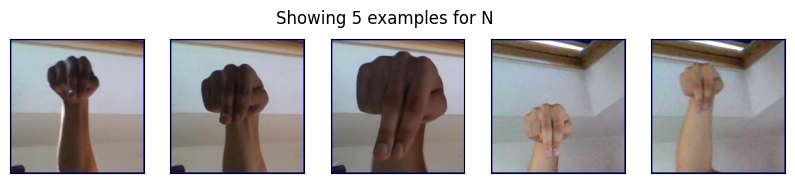

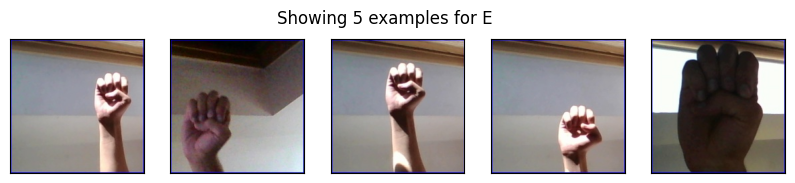

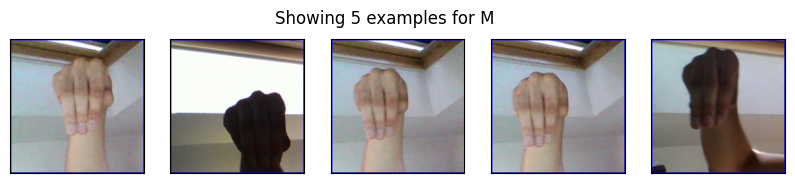

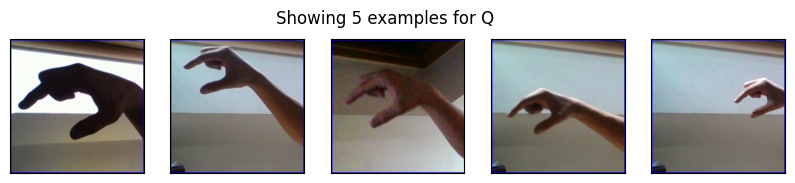

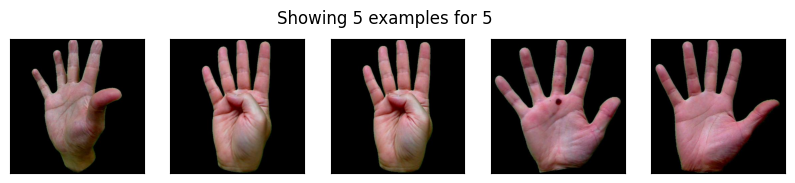

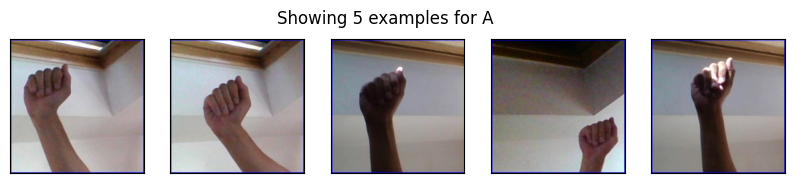

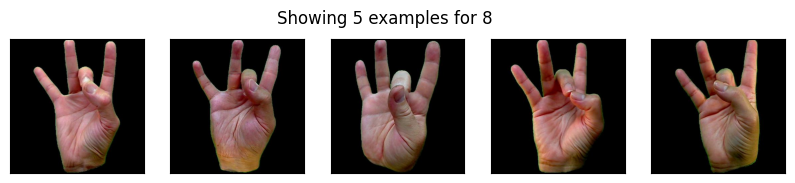

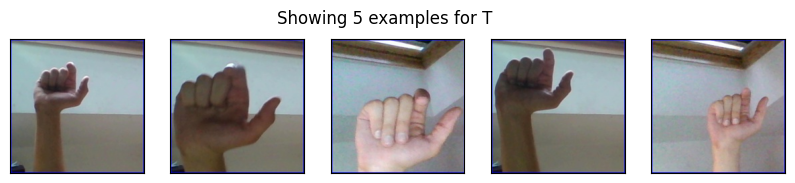

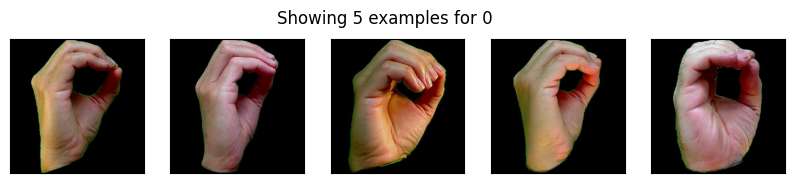

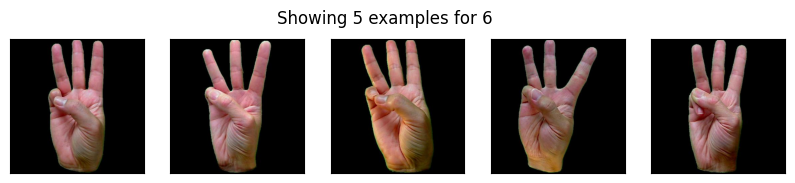

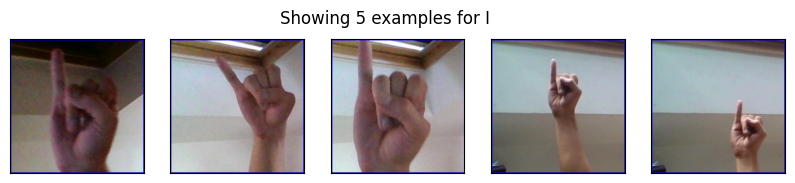

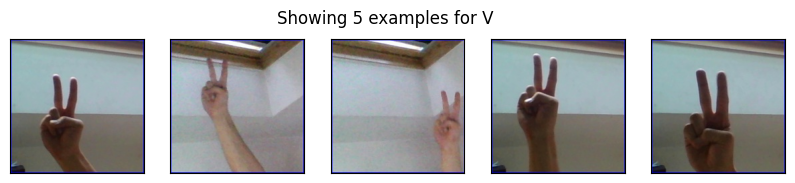

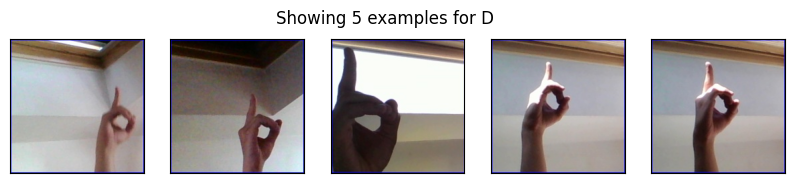

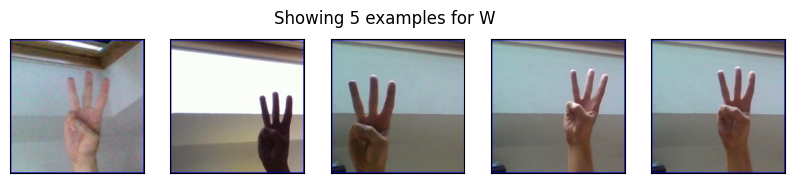

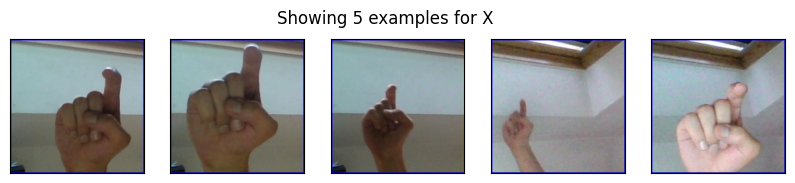

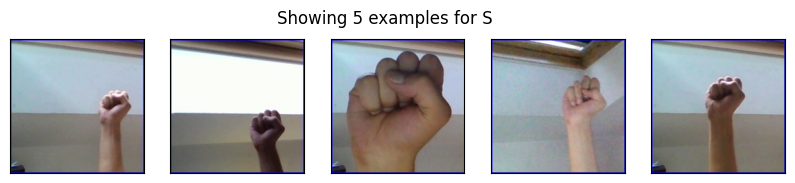

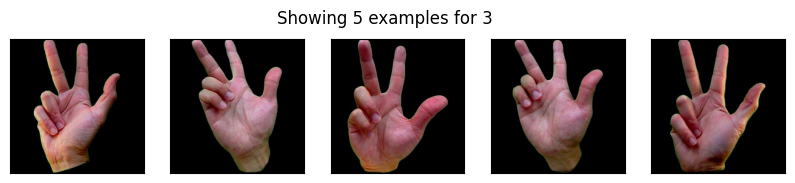

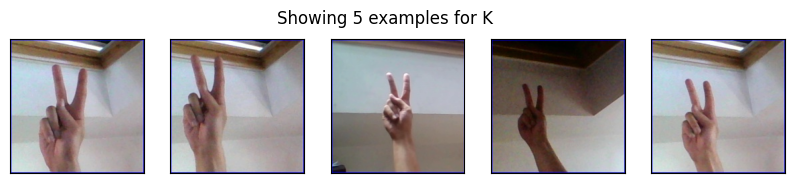

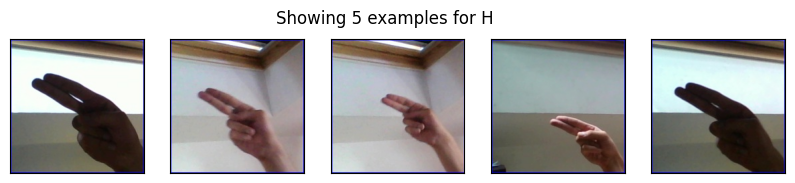

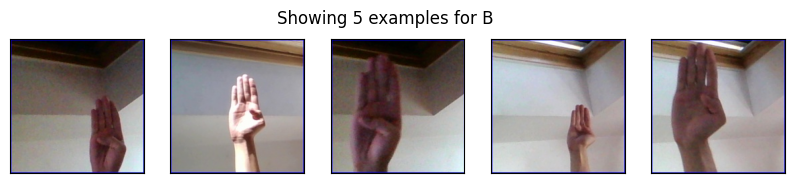

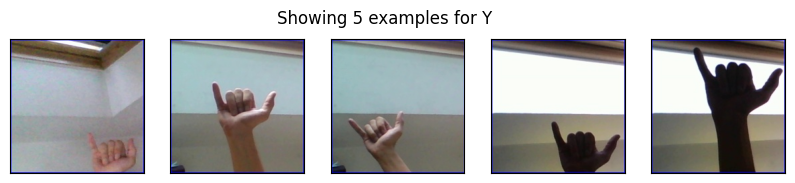

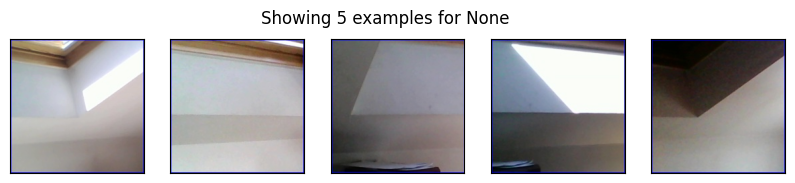

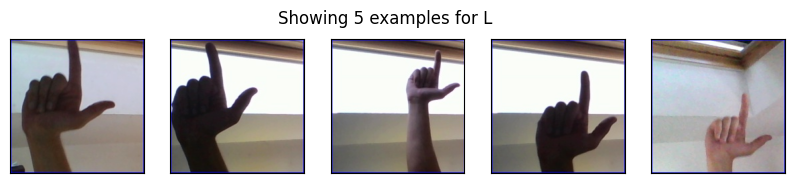

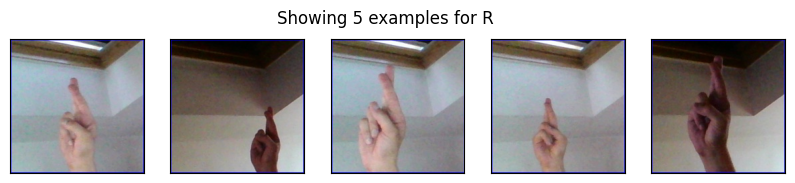

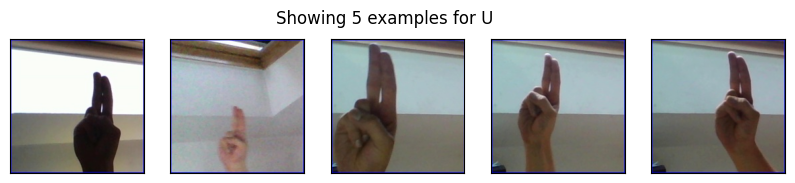

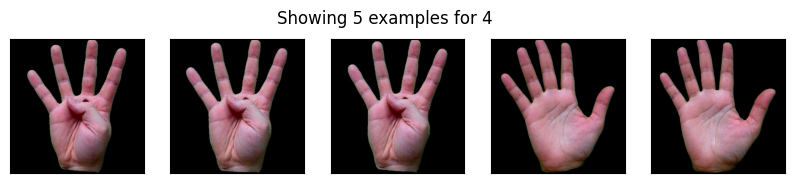

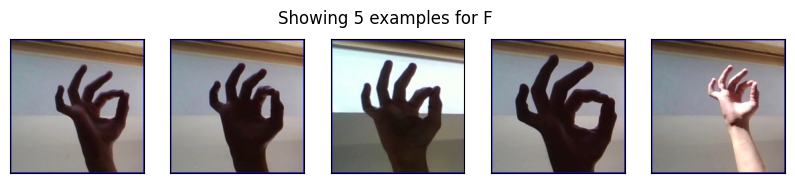

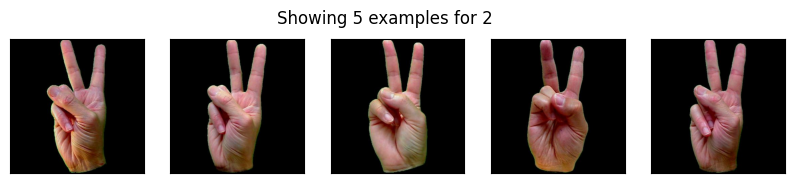

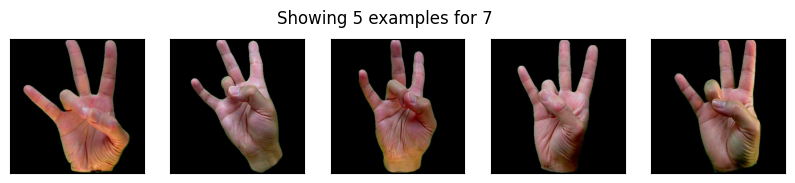

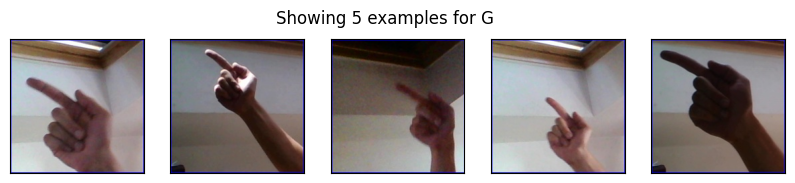

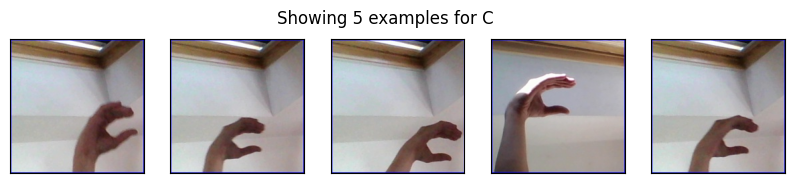

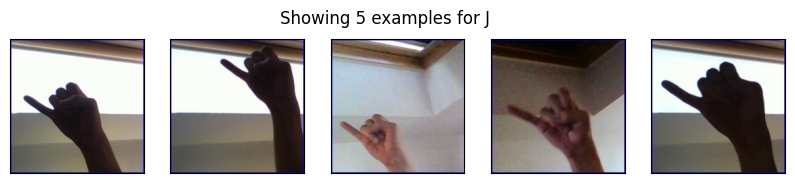

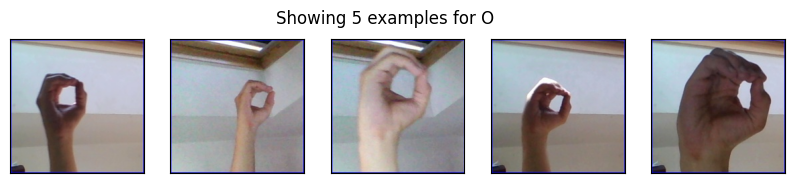

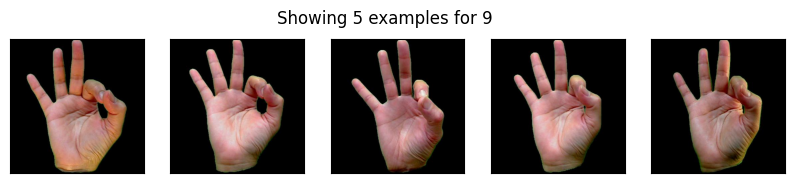

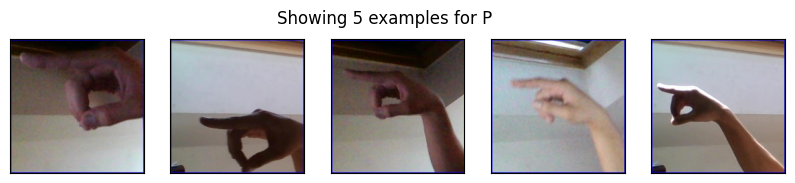

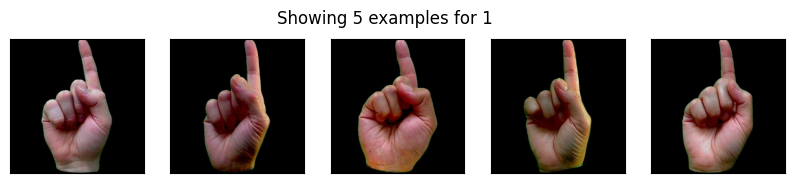

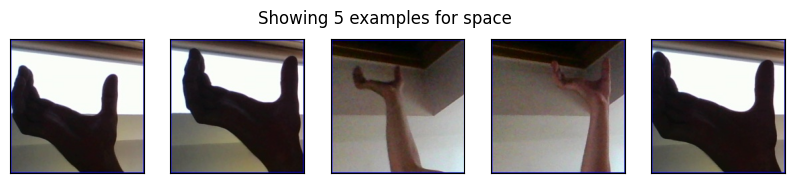

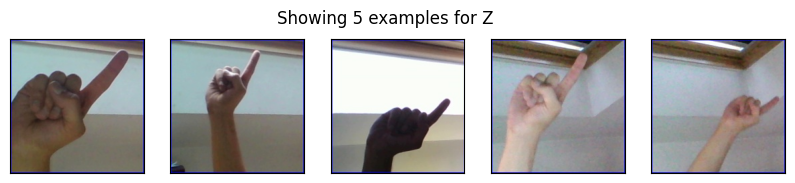

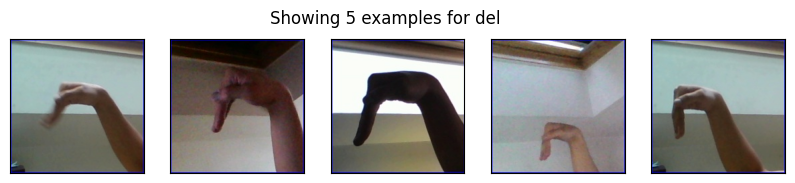

In [ ]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

## **Train Data**
The workflow consists of 4 steps which have been separated into their own code blocks.

**Load the dataset**

Load the dataset located at `dataset_path` by using the `Dataset.from_folder` method. When loading the dataset, run the pre-packaged hand detection model from MediaPipe Hands to detect the hand landmarks from the images. Any images without detected hands are ommitted from the dataset. The resulting dataset will contain the extracted hand landmark positions from each image, rather than images themselves.

The `HandDataPreprocessingParams` class contains two configurable options for the data loading process:
* `shuffle`: A boolean controlling whether to shuffle the dataset. Defaults to true.
* `min_detection_confidence`: A float between 0 and 1 controlling the confidence threshold for hand detection.

Split the dataset: 80% for training, 10% for validation, and 10% for testing.

In [ ]:
data = gesture_recognizer.Dataset.from_folder(
   dataset_path,
   hparams=gesture_recognizer.HandDataPreprocessingParams()
    )
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


## **Train the model**

Train the custom gesture recognizer by using the create method and passing in the training data, validation data, model options, and hyperparameters. For more information on model options and hyperparameters, see the [Hyperparameters](#hyperparameters) section below.

In [ ]:
hparams = gesture_recognizer.HParams(learning_rate=0.005, epochs =20, batch_size=10 ,export_dir="exported_model")
model_options = gesture_recognizer.ModelOptions(dropout_rate=0.2)
options = gesture_recognizer.GestureRecognizerOptions(model_options=model_options, hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options,
)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 39)                5031      
 out (Dense)                                                     
                                                           

## **Evaluate the model performance**

After training the model, evaluate it on a test dataset and print the loss and accuracy metrics.

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss: {loss}, Test accuracy: {acc}")

6025/6025 [==============================] - 47s 3ms/step - loss: 0.0897 - categorical_accuracy: 0.9562
Test loss: 0.08968304097652435, Test accuracy: 0.956182599067688


In [ ]:
log_dir = "/content/exported_model/logs"

### **Export model to tflite for provide more evaluation**

In [ ]:
model.export_tflite("/content/exported_model")

### **Checking structured batch data format mediapipe**

In [ ]:
for batch in test_data.gen_tf_dataset().take(1):
    print("Batch structure:", batch)
    if isinstance(batch, dict):
        for key, value in batch.items():
            print(f"{key} shape:", value.shape)
    else:
        print("Images shape:", batch[0].shape)
        print("Labels shape:", batch[1].shape)
    break

Batch structure: (<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ -3.280198  ,  -5.9049144 ,   2.892265  ,  -6.2034006 ,
         -4.0324726 ,   1.2438372 ,  -4.387807  ,  -2.58407   ,
         -4.958037  ,  -0.9234449 ,  -3.7217722 ,  -6.8061433 ,
         -2.3397868 ,  -8.111745  ,   1.638076  ,  -3.6424866 ,
         -2.8642993 ,  -4.336622  ,  -3.8443553 ,   8.808888  ,
          3.0751595 ,  -3.3008602 ,  -2.181731  ,  -4.72495   ,
         -3.3187149 ,  -7.5203013 ,  -7.8084235 ,   0.8472273 ,
          1.0229508 ,  -3.2626343 ,  -2.9964368 ,  -4.806848  ,
         -2.0572002 ,  -5.8469334 ,  -2.7342541 ,  -8.850138  ,
         -2.780754  ,  -5.4339223 ,  -3.4492462 ,  -2.1039505 ,
         -3.4744852 ,  -2.4841466 ,  -4.8460445 ,  -2.8361452 ,
         -5.028381  ,  -4.5766373 ,   0.07059093,  -1.5897824 ,
         -3.0452023 ,  -5.2852306 ,  -2.33316   ,   0.7816347 ,
         -3.6016595 ,   7.054407  ,   7.216564  ,  -1.7908123 ,
         -6.157574  ,   1.4032876 , 

### **Metric Evaluation**

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def load_tflite_model(tflite_file):
    interpreter = tf.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()
    return interpreter

def predict_tflite(interpreter, input_data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

def get_predictions_tflite(interpreter, dataset):
    predictions = []
    true_labels = []
    for features, labels in dataset.gen_tf_dataset():
        output = predict_tflite(interpreter, features)
        pred_labels = np.argmax(output, axis=1)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        predictions.extend(pred_labels)
    return np.array(predictions), np.array(true_labels)


# Export the model to TFLite
tflite_file = "/content/exported_model/model.tflite"

# Load the TFLite model
interpreter = load_tflite_model(tflite_file)

# Get predictions
y_pred, y_true = get_predictions_tflite(interpreter, test_data)

# Determine unique classes
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
num_classes = len(unique_classes)
print(f"Number of unique classes: {num_classes}")

# Adjust labels to match the number of unique classes
adjusted_labels = labels[:num_classes]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=adjusted_labels))


# Calculate and print additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Number of unique classes: 38

Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00         2
           E       1.00      0.14      0.25         7
           M       0.00      0.00      0.00         5
           Q       1.00      1.00      1.00         6
           5       0.83      0.83      0.83         6
           A       1.00      0.86      0.92         7
           8       0.67      0.67      0.67         3
           T       1.00      1.00      1.00         6
           0       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         7
           I       0.98      0.98      0.98       216
           V       0.99      1.00      1.00       215
           D       0.97      0.97      0.97       179
           W       0.99      0.90      0.94       232
           X       1.00      0.96      0.98       226
           S       0.98      0.98      0.98       252
           3       1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))
print("Original labels:", labels)
print("Adjusted labels:", adjusted_labels)

Unique values in y_true: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Unique values in y_pred: [ 2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38]
Original labels: ['Accuracy', 'Precision', 'Recall', 'F1 Score']
Adjusted labels: ['N', 'E', 'M', 'Q', '5', 'A', '8', 'T', '0', '6', 'I', 'V', 'D', 'W', 'X', 'S', '3', 'K', 'H', 'B', 'Y', 'None', 'L', 'R', 'U', '4', 'F', '2', '7', 'G', 'C', 'J', 'O', '9', 'P', '1', 'space', 'Z']


## Manual save epoch for visualize plot loss and acc


This use manual saving epoch from training into array, so it based on value when training

In [ ]:
import pandas as pd

In [ ]:
data_epochs = [
    [0.1670, 0.9088, 0.1011, 0.9537],
    [0.1652, 0.9071, 0.1040, 0.9558],
    [0.1658, 0.9092, 0.1063, 0.9472],
    [0.1682, 0.9077, 0.1017, 0.9529],
    [0.1676, 0.9082, 0.1017, 0.9525],
    [0.1663, 0.9098, 0.0995, 0.9568],
    [0.1680, 0.9081, 0.1077, 0.9535],
    [0.1653, 0.9080, 0.1059, 0.9519],
    [0.1628, 0.9092, 0.1041, 0.9520],
    [0.1621, 0.9101, 0.1075, 0.9530],
    [0.1643, 0.9105, 0.1029, 0.9495],
    [0.1631, 0.9094, 0.1043, 0.9550],
    [0.1622, 0.9088, 0.1090, 0.9505],
    [0.1629, 0.9103, 0.1016, 0.9543],
    [0.1631, 0.9109, 0.1050, 0.9552],
    [0.1622, 0.9102, 0.1025, 0.9567],
    [0.1611, 0.9107, 0.1076, 0.9509],
    [0.1607, 0.9119, 0.1094, 0.9530],
    [0.1619, 0.9110, 0.1130, 0.9441],
    [0.1597, 0.9092, 0.1078, 0.9497],
]
df_data_epochs = pd.DataFrame(data_epochs, columns=['loss', 'accuracy', 'val_loss', 'val_accuracy'])

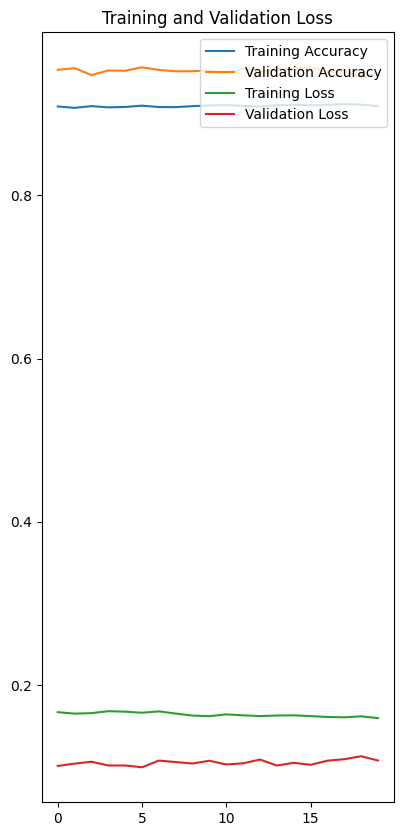

In [ ]:
epochs_range = range(20)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range, df_data_epochs['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, df_data_epochs['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,1)
plt.plot(epochs_range, df_data_epochs['loss'], label='Training Loss')
plt.plot(epochs_range, df_data_epochs['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

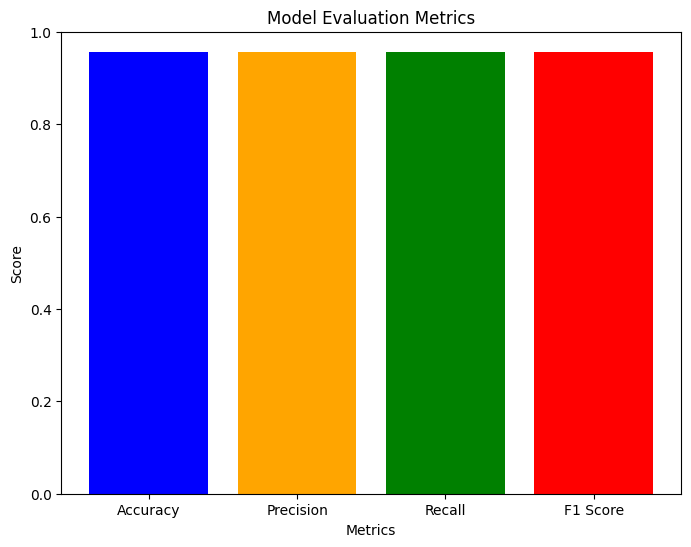

In [ ]:
# Metrics
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Plotting the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()


## Radar Chart

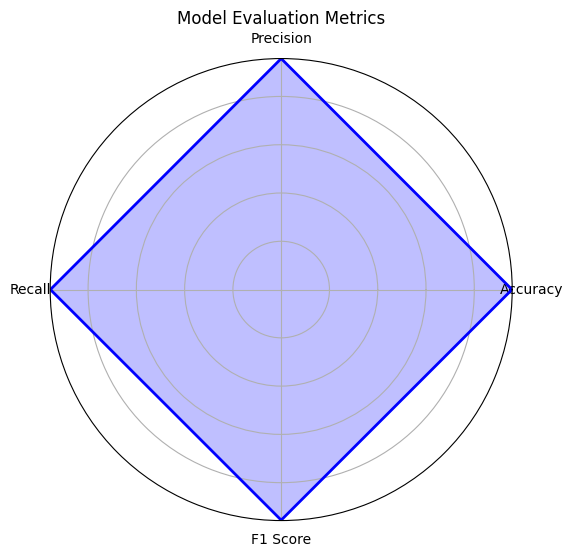

In [ ]:
from math import pi

# Prepare data
labels = list(metrics.keys())
values = list(metrics.values())
num_vars = len(labels)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
values += values[:1]
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Model Evaluation Metrics')
plt.show()


## Normalized Confusion Matrix

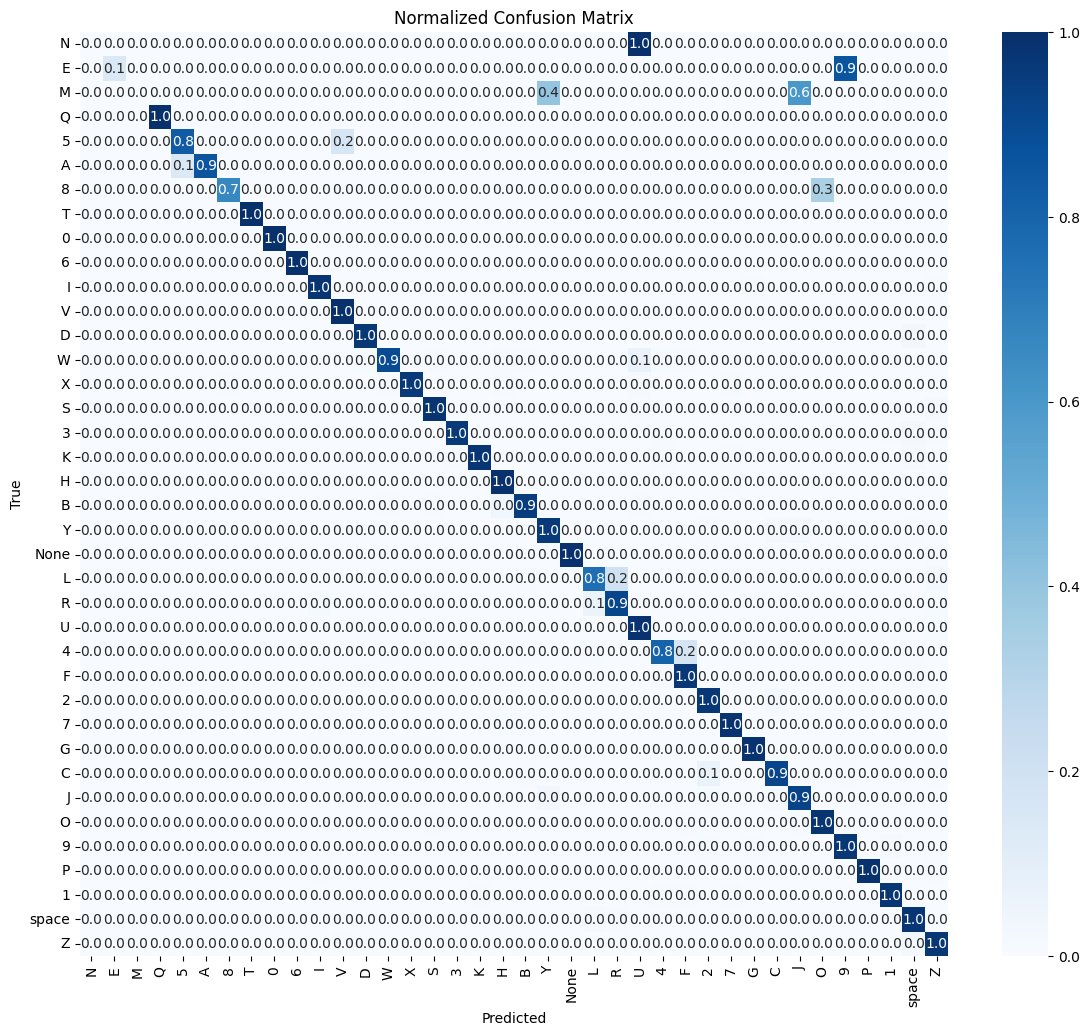

In [ ]:
# Normalized confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.1f', cmap='Blues', xticklabels=adjusted_labels, yticklabels=adjusted_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


## If wanna split dataset with img format


In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders

# # Path ke dataset

# output_folder = '/content/asl_alphabet_train_2'

# # Membagi dataset dengan perbandingan 80% train, 10% validation, dan 10% test
# splitfolders.ratio(dataset_path, output=output_folder, seed=1337, ratio=(.8, .1, .1))


Copying files: 87700 files [01:26, 1015.93 files/s]


**Export to Tensorflow Lite Model**

After creating the model, convert and export it to a Tensorflow Lite model format for later use on an on-device application. The export also includes model metadata, which includes the label file.

In [ ]:
model.export_model()
!ls exported_model

In [ ]:
files.download('exported_model/gesture_recognizer.task')

## Run the model on-device

To use the TFLite model for on-device usage through MediaPipe Tasks, refer to the Gesture Recognizer [overview page](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer).

## Hyperparameters {:#hyperparameters}


You can further customize the model using the `GestureRecognizerOptions` class, which has two optional parameters for `ModelOptions` and `HParams`. Use the `ModelOptions` class to customize parameters related to the model itself, and the `HParams` class to customize other parameters related to training and saving the model.

`ModelOptions` has one customizable parameter that affects accuracy:
* `dropout_rate`: The fraction of the input units to drop. Used in dropout layer. Defaults to 0.05.
* `layer_widths`: A list of hidden layer widths for the gesture model. Each element in the list will create a new hidden layer with the specified width. The hidden layers are separated with BatchNorm, Dropout, and ReLU. Defaults to an empty list(no hidden layers).

`HParams` has the following list of customizable parameters which affect model accuracy:
* `learning_rate`: The learning rate to use for gradient descent training. Defaults to 0.001.
* `batch_size`: Batch size for training. Defaults to 2.
* `epochs`: Number of training iterations over the dataset. Defaults to 10.
* `steps_per_epoch`: An optional integer that indicates the number of training steps per epoch. If not set, the training pipeline calculates the default steps per epoch as the training dataset size divided by batch size.
* `shuffle`: True if the dataset is shuffled before training. Defaults to False.
* `lr_decay`: Learning rate decay to use for gradient descent training. Defaults to 0.99.
* `gamma`: Gamma parameter for focal loss. Defaults to 2

Additional `HParams` parameter that does not affect model accuracy:
* `export_dir`: The location of the model checkpoint files and exported model files.

For example, the following trains a new model with the dropout_rate of 0.2 and learning rate of 0.003.

In [ ]:
# hparams = gesture_recognizer.HParams(learning_rate=0.003, export_dir="exported_model_2")
# model_options = gesture_recognizer.ModelOptions(dropout_rate=0.2)
# options = gesture_recognizer.GestureRecognizerOptions(model_options=model_options, hparams=hparams)
# model_2 = gesture_recognizer.GestureRecognizer.create(
#     train_data=train_data,
#     validation_data=validation_data,
#     options=options
# )

Evaluate the newly trained model.

In [ ]:
# loss, accuracy = model_2.evaluate(test_data)
# print(f"Test loss:{loss}, Test accuracy:{accuracy}")